In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import altair as alt
import requests
from bs4 import BeautifulSoup


In [2]:
def get_data():
    data_url = r"C:\Users\Nikit\PycharmProjects\COVID19_visualization\covid_data_cleaned.csv"
    return pd.read_csv(data_url)


df = get_data()
df1 = pd.read_excel(r"C:\Users\Nikit\PycharmProjects\COVID19_visualization\time_series_covid19_confirmed_global.xls", engine='xlrd')

In [3]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.dropna(subset=['total_cases', 'total_deaths', 'people_fully_vaccinated'])

df['deaths_per_case'] = df['total_deaths'] / df['total_cases'] 
df['deaths_per_vaccine'] = df['total_deaths'] / df['people_fully_vaccinated'] 
countries = list(df['location'].unique())
continents = list(df['continent'].unique())
continents = [continent for continent in continents if not (pd.isnull(continent)) == True]

In [4]:
r = requests.get("https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population")
soup = BeautifulSoup(r.text, features="html.parser")

population_list = []
for i in range(2, 243):
    population_list.append([soup.find(class_="wikitable").find_all("tr")[i].find('td').text.strip(),
                        int(soup.find(class_="wikitable").find_all("tr")[i].find_all('td')[1].text.strip().replace(",", ""))])
    
population_df = pd.DataFrame(population_list, columns=['location', 'population'])
df = df.merge(population_df, on='location', how='inner')

countries_for_vaccines = df.location.unique().tolist()
deaths_vaccines_cases_perc = []
for country in countries_for_vaccines:
    deaths_vaccines_cases_perc.append([country,
                                             float(100 * df[df['location'] == country]['total_deaths'].tail(1) / 
                                                 df[df['location'] == country]['population'].tail(1)),
                                             float(100 * df[df['location'] == country]['people_fully_vaccinated'].tail(1) /
                                                 df[df['location'] == country]['population'].tail(1)),
                                             float(100 * df[df['location'] == country]['total_cases'].tail(1) / 
                                                 df[df['location'] == country]['population'].tail(1))
                                             ])

mort_vacc_morb_df = pd.DataFrame(deaths_vaccines_cases_perc,
                                 columns=['location', 'mortality_rate', 'vaccinated_rate', 'morbidity_rate'])


mort_vacc_morb_df = mort_vacc_morb_df.merge(df[['location','continent']].groupby(by='location', as_index=False).min(), 
                                            on='location')

In [5]:
mort_vacc_morb_df[mort_vacc_morb_df['location'] == 'France']

,location,mortality_rate,vaccinated_rate,morbidity_rate,continent
56,France,0.214436,77.073583,42.157735,Europe


In [6]:
mort_vacc_morb_df

,location,mortality_rate,vaccinated_rate,morbidity_rate,continent
0,Afghanistan,0.022424,13.534567,0.521874,Asia
1,Albania,0.126585,44.567408,9.952332,Europe
2,Algeria,0.015143,14.275740,0.585423,Africa
3,Andorra,0.183183,63.941669,48.283706,Europe
4,Angola,0.005743,19.125472,0.300085,Africa
...,...,...,...,...,...
178,Venezuela,0.020055,50.481839,1.837460,South America
179,Vietnam,0.042014,77.754108,8.338914,Asia
180,Yemen,0.006736,1.313271,0.037060,Asia
181,Zambia,0.020275,12.445234,1.630507,Africa


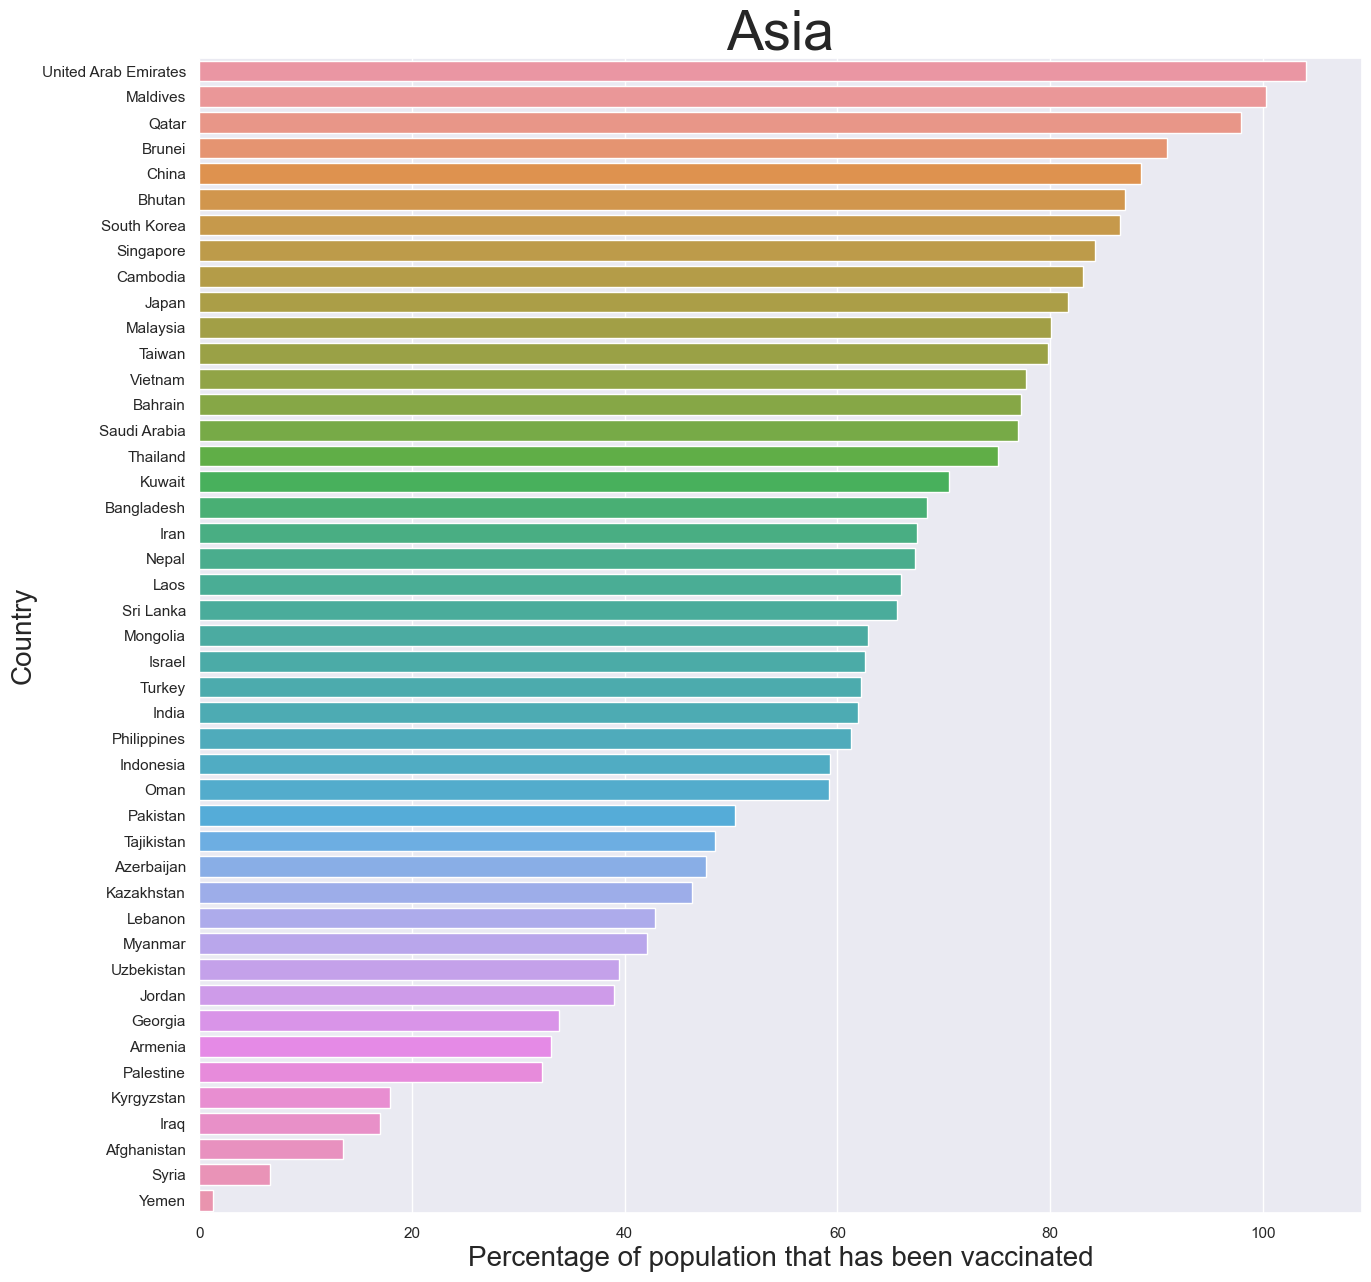

In [7]:
option_continents = 'Asia'

sns.set(font_scale=0.8)
sns.set(rc={'figure.figsize': (15,
                               len(list(mort_vacc_morb_df[mort_vacc_morb_df['continent'] ==
                                                                    option_continents]['location'])) / 3)})
ax = sns.barplot(x="vaccinated_rate", y="location",
                 data=mort_vacc_morb_df[
                     mort_vacc_morb_df['continent'] == option_continents].sort_values(
                     by='vaccinated_rate', ascending=False))
ax.set_title(option_continents, fontsize=40)
ax.set_xlabel('Percentage of population that has been vaccinated', fontsize=20);
ax.set_ylabel('Country', fontsize=20);

In [8]:
len(list(mort_vacc_morb_df[mort_vacc_morb_df['continent'] ==option_continents]['location'])) / 100

0.45

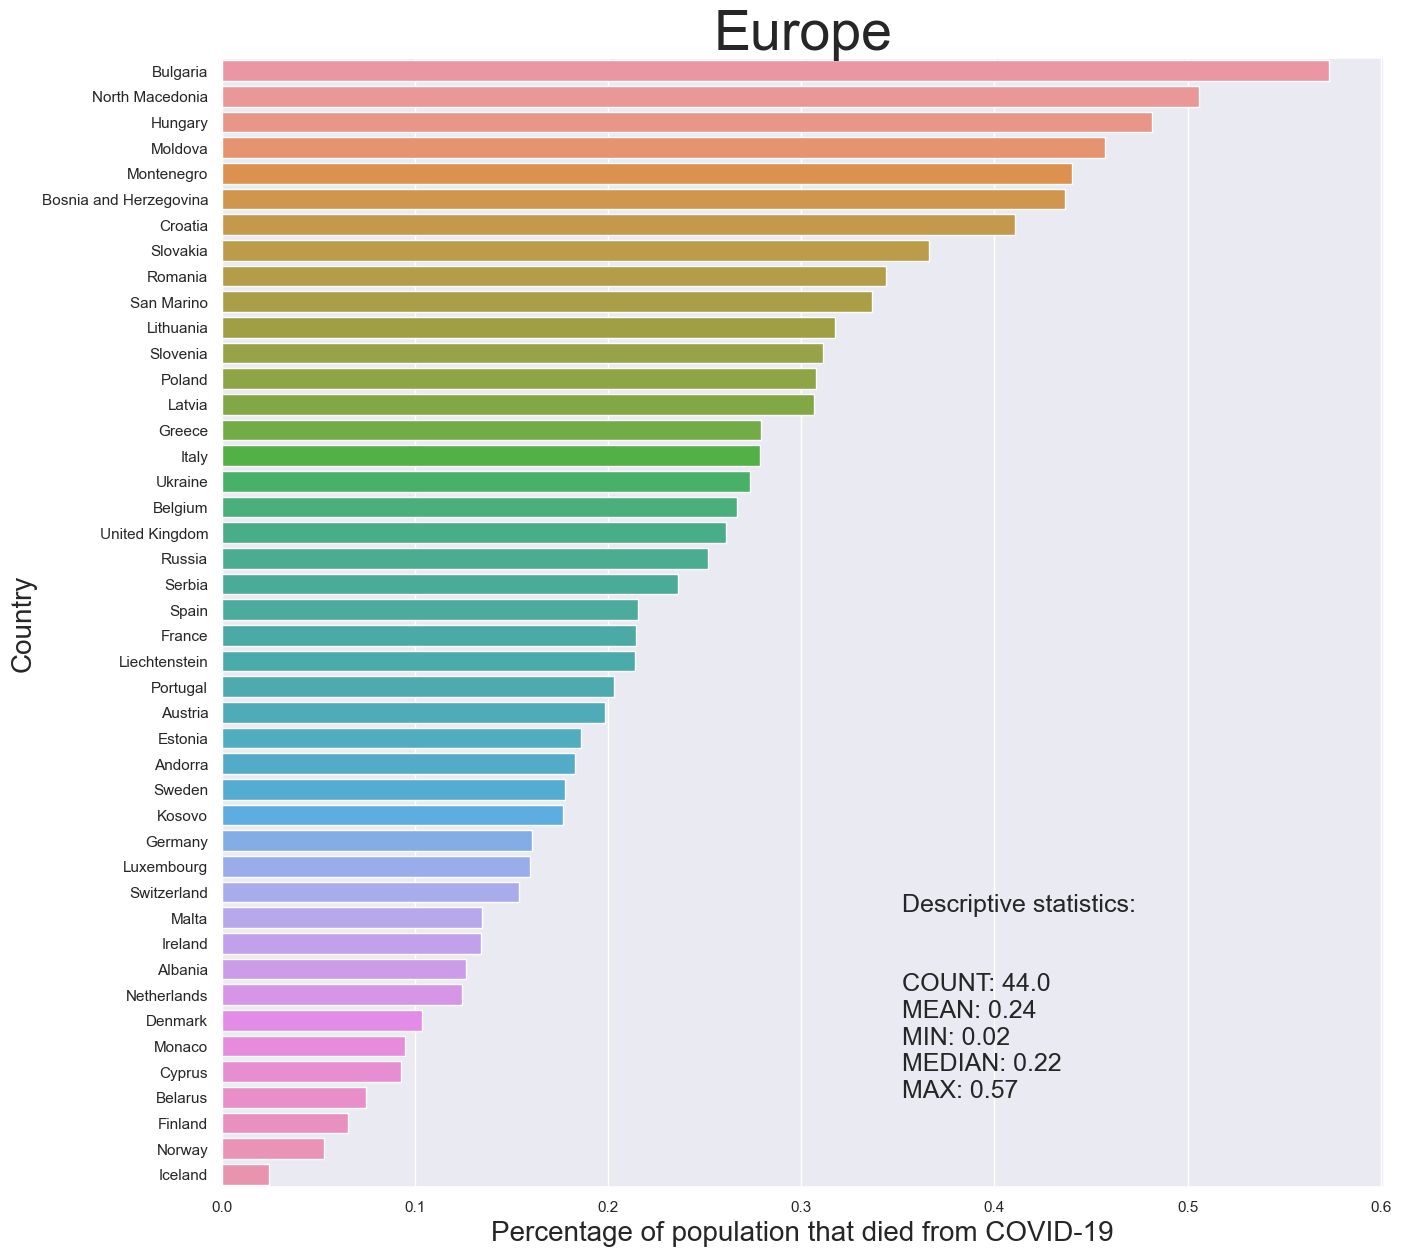

In [9]:
option_continents = 'Europe'

sns.set(font_scale=0.8)
sns.set(rc={'figure.figsize': (15,
                               len(list(mort_vacc_morb_df[mort_vacc_morb_df['continent'] ==
                                                                    option_continents]['location'])) / 3)})
ax = sns.barplot(x="mortality_rate", y="location",
                 data=mort_vacc_morb_df[
                     mort_vacc_morb_df['continent'] == option_continents].sort_values(
                     by=['mortality_rate'], ascending=False))
ax.set_title(option_continents, fontsize=40)
ax.set_xlabel('Percentage of population that died from COVID-19', fontsize=20);
ax.set_ylabel('Country', fontsize=20)


descript_stats = mort_vacc_morb_df[mort_vacc_morb_df['continent'] == option_continents]['mortality_rate'].describe()
ax.text(len(list(mort_vacc_morb_df[mort_vacc_morb_df['continent'] ==option_continents]['location'])) / 125
        , 40, 
        f"""
Descriptive statistics:\n\n        
COUNT: {descript_stats[0]}
MEAN: {round(descript_stats[1],2)}
MIN: {round(descript_stats[3],2)}
MEDIAN: {round(descript_stats[5],2)}
MAX: {round(descript_stats[7],2)}""",
rotation = 0,
fontsize = 18) ;

In [10]:
mort_vacc_morb_df[mort_vacc_morb_df['continent'] == option_continents]['mortality_rate'].describe()

count    44.000000
mean      0.243562
std       0.131564
min       0.024436
25%       0.149220
50%       0.215012
75%       0.312992
max       0.573025
Name: mortality_rate, dtype: float64

In [11]:
pd.DataFrame(mort_vacc_morb_df[mort_vacc_morb_df['continent'] == option_continents]['vaccinated_rate'].describe())

,vaccinated_rate
count,44.000000
mean,63.662368
std,15.271407
min,25.818091
25%,50.801178
50%,66.945532
75%,73.402260
max,90.145353


In [12]:
len(list(mort_vacc_morb_df[mort_vacc_morb_df['continent'] ==option_continents]['location'])) / 3

14.666666666666666

In [13]:
def get_data():
    data_url = r"C:\Users\Nikit\PycharmProjects\COVID19_visualization\covid_data_cleaned.csv"
    return pd.read_csv(data_url)

df = get_data()
df1 = pd.read_excel(r"C:\Users\Nikit\PycharmProjects\COVID19_visualization\time_series_covid19_confirmed_global.xls", engine='xlrd')
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.dropna(subset=['total_cases', 'total_deaths'])
df = df.drop(["total_vaccinations", "new_cases", "new_deaths", "total_boosters", "new_vaccinations", "people_vaccinated"], axis=1)

df['deaths/cases, %'] = df['total_deaths']/df['total_cases']*100
df['deaths/vaccines'] = df['total_deaths']/df['people_fully_vaccinated']*100
countries = list(df['location'].unique())
continents = list(df['continent'].unique())
continents = [continent for continent in continents if not (pd.isnull(continent)) == True]

lists = []
for country in countries:
    x = np.array(df[df['location']==country]['date']).reshape((-1,1))
    y = df[df['location']==country]['deaths/cases, %']
    model = LinearRegression().fit(x, y)
    lists.append([country, round(float(100000000000000000*model.coef_), 2)])

pares = pd.DataFrame(lists, columns=['country', 'slope'])
df = df.merge(pares, left_on='location', right_on='country').drop(['country'], axis=1)

triple = []
for country in countries:
    triple.append([country, df[df['location']==country]['continent'].unique()[0], df[df['location']==country]['slope'].unique()[0]])
triple_df = pd.DataFrame(triple, columns=['country', 'continent', 'slope']).dropna()

"""
The first thing which is interesting to scrutinize is what part of people who got sick with COVID-19 died 
from it in different countries, and how countries struggled with this mortality problem on all extent from February 2020 to May 2022. 
The following plot allows you to visually compare what percentage of sick with COVID-19 people died in any countries.
"""





r = requests.get("https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population")
soup = BeautifulSoup(r.text, features="html.parser")

population_list = []
for i in range(2, 243):
    population_list.append([soup.find(class_="wikitable").find_all("tr")[i].find('td').text.strip(),
                            float(soup.find(class_="wikitable").find_all("tr")[i].find_all('td')[
                                    2].text.strip().replace(",", "").replace("%", ""))])
population_df = pd.DataFrame(population_list, columns=['country', 'population'])

df = df.merge(population_df, left_on='location', right_on='country', how='left').drop(['country'], axis=1)

df_without_nan = df.copy()
df_without_nan = df_without_nan.dropna()
df_without_nan['population'] = df_without_nan['population'].replace(0, 0.01)

countries_for_vaccines = list(df_without_nan['location'].unique())
list_perc_of_deaths_and_vaccines = []
for country in countries_for_vaccines:
    list_perc_of_deaths_and_vaccines.append([country,
                                             100 * int(
                                                 df[df['location'].isin([country])].tail(1)['total_deaths']) / float(
                                                 df_without_nan[df_without_nan['location'].isin([country])].tail(1)[
                                                     'population']),
                                             100 * int(
                                                 df_without_nan[df_without_nan['location'].isin([country])].tail(1)[
                                                     'people_fully_vaccinated']) / float(
                                                 df_without_nan[df_without_nan['location'].isin([country])].tail(1)[
                                                     'population']),
                                             100 * int(
                                                 df_without_nan[df_without_nan['location'].isin([country])].tail(1)[
                                                     'total_cases']) / float(
                                                 df_without_nan[df_without_nan['location'].isin([country])].tail(1)[
                                                     'population'])
                                             ])

mortality_and_vaccinated_df = pd.DataFrame(list_perc_of_deaths_and_vaccines,
                                           columns=['country', 'perc. of mortality', 'perc. of vacc', 'perc. of morbidity'])
mortality_and_vaccinated_df = mortality_and_vaccinated_df.merge(triple_df, left_on='country', right_on='country',
                                                                how='left')

"""
The second thing that is curious to know is what part of population in each country 
from all over the world has died and has vaccinated since February 2020.
"""
"""
Now you can choose one continent and compare what percentage of population 
from countries that are on selected continent were vaccinated or died.
"""

option_continents = st.radio("Choose a continent that you want to consider", continents)
sns.set(font_scale=0.8)
sns.set(rc={'figure.figsize': (15,
                               len(list(mortality_and_vaccinated_df[mortality_and_vaccinated_df['continent'] ==
                                                                    option_continents ]['country'])) / 3)})
ax = sns.barplot(x="perc. of vacc", y="country",
            data=mortality_and_vaccinated_df[mortality_and_vaccinated_df['continent'] == option_continents].sort_values(
                by=['perc. of vacc']))
ax.set_title(option_continents, fontsize=40)
ax.set_xlabel('Percentage of population that has been vaccinated', fontsize=20);
ax.set_ylabel('Country', fontsize=20);

st.set_option('deprecation.showPyplotGlobalUse', False)


sns.set(font_scale=0.6)
sns.set(rc={'figure.figsize': (15,
                               len(list(mortality_and_vaccinated_df[mortality_and_vaccinated_df['continent'] ==
                                                                    option_continents]['country'])) / 3)})
ax = sns.barplot(x="perc. of mortality", y="country",
                 data=mortality_and_vaccinated_df[
                     mortality_and_vaccinated_df['continent'] == option_continents].sort_values(
                     by=['perc. of mortality'], ascending=False))
ax.set_title(option_continents, fontsize=40)
ax.set_xlabel('Percentage of population that died from COVID-19', fontsize=20);
ax.set_ylabel('Country', fontsize=20);


"""
The third thing that you may be interested in is the morbidity from COVID-19. The following heatmap 
gives you the opportunity to learn what percentage of population in each country has been infected with Coronavirus.
The wider a circle is, the larger percentage of the population was infected.
"""
df1 = df1[['Country', 'Lat', 'Long']]
mortality_and_vaccinated_df = mortality_and_vaccinated_df.merge(df1, left_on='country', right_on='Country',
                                                                how='left')


"""
Data sources: 
1) https://www.kaggle.com/datasets/digvijaysinhgohil/covid19-data-deaths-and-vaccinations?select=covid_data_cleaned.csv
2) https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
3) https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population
"""

NameError: name 'st' is not defined

In [44]:
df_without_nan

414       0.4
423       0.4
427       0.4
429       0.4
430       0.4
         ... 
158460    0.2
158461    0.2
158462    0.2
158463    0.2
158464    0.2
Name: population, Length: 35811, dtype: float64

In [45]:
df_without_nan[df_without_nan['location'].isin([country])].tail(1)['population']

KeyError: 'location'

In [39]:
for country in countries_for_vaccines:
    list_perc_of_deaths_and_vaccines.append([country,
                                             100 * int(
                                                 df[df['location'].isin([country])].tail(1)['total_deaths']) / int(
                                                 df_without_nan[df_without_nan['location'].isin([country])].tail(1)[
                                                     'population']),
                                             100 * int(
                                                 df_without_nan[df_without_nan['location'].isin([country])].tail(1)[
                                                     'people_fully_vaccinated']) / int(
                                                 df_without_nan[df_without_nan['location'].isin([country])].tail(1)[
                                                     'population']),
                                             100 * int(
                                                 df_without_nan[df_without_nan['location'].isin([country])].tail(1)[
                                                     'total_cases']) / int(
                                                 df_without_nan[df_without_nan['location'].isin([country])].tail(1)[
                                                     'population'])
                                             ])

ZeroDivisionError: division by zero

In [40]:
df_without_nan.population

414       0.4
423       0.4
427       0.4
429       0.4
430       0.4
         ... 
158460    0.2
158461    0.2
158462    0.2
158463    0.2
158464    0.2
Name: population, Length: 35811, dtype: float64